# Project Report

Quang Duy Do, Jingjing Li, Wendy Li, Lucia Lu

### Introduction

The term “heart disease” refers to several types of heart conditions. The most common type of heart disease in the United States is coronary artery disease (CAD), which affects the blood flow to the heart. (Heart Disease Resources | Cdc.gov, 2023) Decreased blood flow can cause a heart attack.
Many factors contribute to heart disease, including blood pressure and cholesterol levels. (Know Your Risk for Heart Disease | cdc.gov, 2023) Age also has a potential influence on heart disease. Heart disease is primarily symptomatic when it occurs, but it can be prevented by everyday signs such as exercising for angina. (Professional, n.d.)

Too much LDL cholesterol in the blood causes plaque to build up in the arteries. The buildup cuts blood flow and leads to heart and blood vessel conditions. The LDL cholesterol level should be less than 130 mg/dL (3.4 mmol/L). (Blood Tests for Heart Disease, 2023)

Angina pain happens when your heart muscle does not get as much oxygen-rich blood as it needs. An angina event does not cause permanent damage to the heart. However, your angina may turn into a heart attack if the cells in your heart do not get enough oxygen for too long, and they start to die. (Causes and Risk Factors | NHLBI, NIH, 2023)

This project aims to predict a patient's likelihood of developing heart disease using factors such as age, cholesterol levels, and whether or not angina occurs with exercise.

We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:

- 1.**age**: age
- 2.**sex**: sex (1 = male, 0 = female)
- 3.**cp**: chest pain type
- 4.**trestbps**: resting blood pressure in mmHg
- 5.**chol**: serum cholestoral in mg/dl
- 6.**fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
- 7.**restecg**: resting electrocardiographic results
- 8.**thalach**: maximum heart rate achieved
- 9.**exang**: whether exercise induced angina (1 = True, 0 = False)
- 10.**oldpeak**: ST depression induced by exercise, relative to rest
- 11.**slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
- 12.**ca**: number of major vessels (0-3) coloured by flourosopy
- 13.**thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
- 14.**num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Based on the list above, we will be using `age`, and `chol` as predictors, to classify patients on whether or not they have heart disease.

## Method and Results

### Loading in dataset and Wrangling

EXPLANATION HERE

#### Importing Libraries and Setting Graph Format

In [50]:
# Install package themis
# install.packages("themis")


# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
# library(themis)
library(RColorBrewer)

# construct a recipe that upscales

# formatting graphs
options(repr.plot.width = 12, repr.plot.height = 6)

#### Importing dataset

In [51]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                          col_names = FALSE)

head(cleveland_data)

nrow(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1 X2 X3 X4  X5  X6 X7 X8  X9 X10 X11 X12 X13 X14
1 63 1  1  145 233 1  2  150 0  2.3 3   0.0 6.0 0  
2 67 1  4  160 286 0  2  108 1  1.5 2   3.0 3.0 2  
3 67 1  4  120 229 0  2  129 1  2.6 2   2.0 7.0 1  
4 37 1  3  130 250 0  0  187 0  3.5 3   0.0 3.0 0  
5 41 0  2  130 204 0  2  172 0  1.4 1   0.0 3.0 0  
6 56 1  2  120 236 0  0  178 0  0.8 1   0.0 3.0 0

[1] 303

In [52]:
set.seed(12)

cleveland_clean <- cleveland_data

# Adding column names:
# 1. Age
# 2. Sex
# 3. Cp
# 4. trestbps
# 5. chol
# 6. fbs
# 7. restcg
# 8. thalach
# 9. exang
# 10. oldpeak
# 11. slope
# 12. ca
# 13. thal
# 14. num

colnames(cleveland_clean) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_clean <- cleveland_clean |>
                mutate(sex = as.factor(as.integer(sex)),
                       diag = as.factor(ifelse(is.na(num), NA, (num > 0))),
                      num = as.factor(as.integer(num))) # Since sex is a dummy variable that is either male(1) and female(0)

# changing "?" into NA
cleveland_clean[ cleveland_clean == "?" ] <- NA

head(cleveland_clean)

# see how many observations have NA
cleveland_na <- sum(is.na(cleveland_clean))
cleveland_na



age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca  thal num
1 63  1   1  145      233  1   2       150     0     2.3     3     0.0 6.0  0  
2 67  1   4  160      286  0   2       108     1     1.5     2     3.0 3.0  2  
3 67  1   4  120      229  0   2       129     1     2.6     2     2.0 7.0  1  
4 37  1   3  130      250  0   0       187     0     3.5     3     0.0 3.0  0  
5 41  0   2  130      204  0   2       172     0     1.4     1     0.0 3.0  0  
6 56  1   2  120      236  0   0       178     0     0.8     1     0.0 3.0  0  
  diag 
1 FALSE
2 TRUE 
3 TRUE 
4 FALSE
5 FALSE
6 FALSE

[1] 6

In [53]:
# As there are only 6 obervations have NA, which is very small, we do not have to replace those NA with the mean
# Check the number of different distinct values of num
cleveland_see <- cleveland_clean |> distinct(diag)
cleveland_see

# Drop the NA
cleveland_clean <- drop_na(cleveland_clean)

diag 
1 FALSE
2 TRUE

### Methods and Results

EXPLANATION HERE

### Splitting the data

EXPLANATION HERE

In [54]:
set.seed(12)


# cleveland_split <- initial_split(cleveland_select, prop = 0.75, strata = num)

cleveland_split <- initial_split(cleveland_clean, prop = 0.75, strata = diag)

cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)

nrow(cleveland_train)
nrow(cleveland_test)

age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca  thal num
1 63  1   1  145      233  1   2       150     0     2.3     3     0.0 6.0  0  
2 37  1   3  130      250  0   0       187     0     3.5     3     0.0 3.0  0  
3 41  0   2  130      204  0   2       172     0     1.4     1     0.0 3.0  0  
4 56  1   2  120      236  0   0       178     0     0.8     1     0.0 3.0  0  
5 57  0   4  120      354  0   0       163     1     0.6     1     0.0 3.0  0  
6 57  1   4  140      192  0   0       148     0     0.4     2     0.0 6.0  0  
  diag 
1 FALSE
2 FALSE
3 FALSE
4 FALSE
5 FALSE
6 FALSE

[1] 222

[1] 75

EXPLANATION HERE

### Summarizing the data

EXPLANATION HERE

In [55]:
cleveland_summary <- cleveland_train |>
                    group_by(diag) |>
                    summarize(mean_chol = mean(chol),
                    mean_age = mean(age))

cleveland_false <- cleveland_train |>
                    filter(diag == "FALSE") |>
                    nrow()

cleveland_true <- cleveland_train |>
                    filter(diag == "TRUE") |>
                    nrow()

# Calculate the number of false diag
print("False Diag number:")
cleveland_false

# Calculate the number of true diag
print("True Diag number:")
cleveland_true

print("Summary:")
cleveland_summary

[1] "False Diag number:"


[1] 120

[1] "True Diag number:"


[1] 102

[1] "Summary:"


diag  mean_chol mean_age
1 FALSE 245.8583  52.53333
2 TRUE  248.7451  56.79412

EXPLANATION HERE ( EXPLAIN THAT FALSE AND TRUE DIAG NUMBERS ARE SIMILAR, SO THERE IS NO NEED TO ste_upsample() THE DATA IN THE RECIPE)

#### Visualizing the realtionship between predictors and class

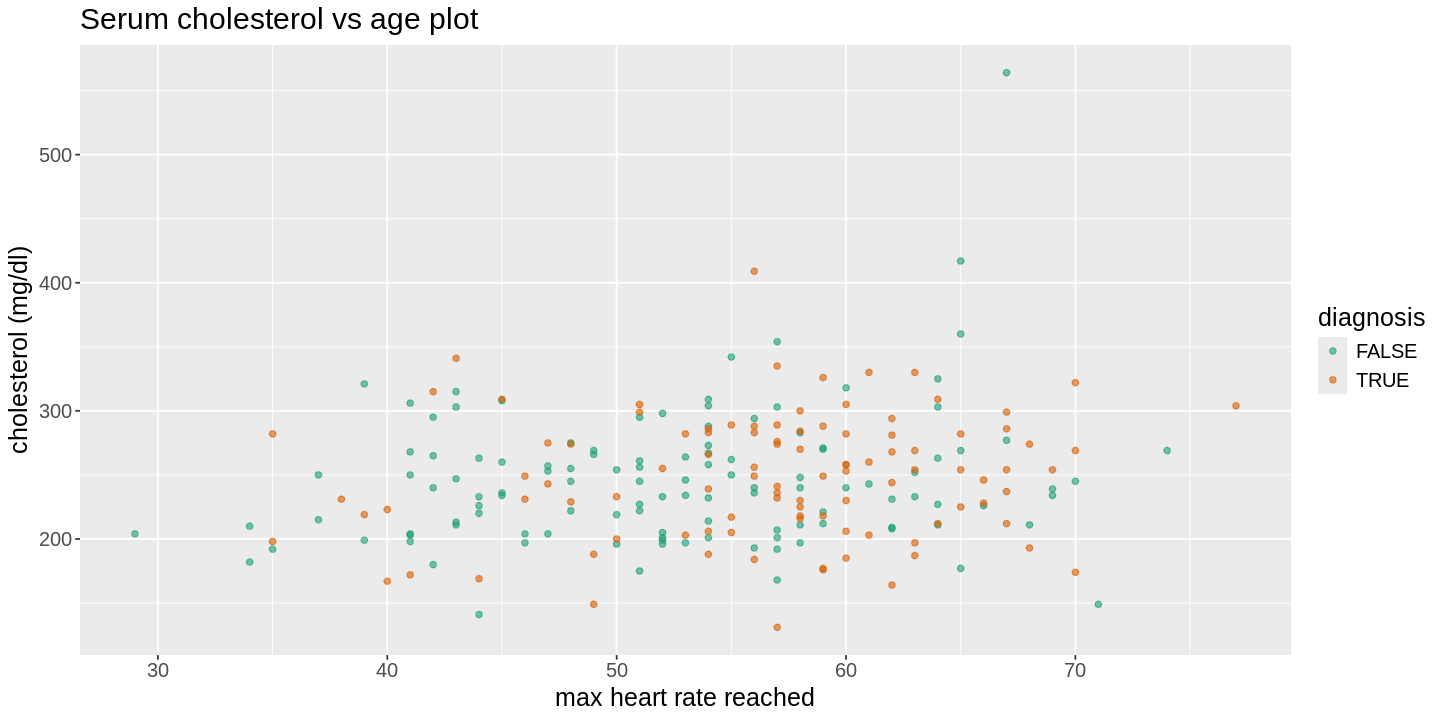

In [56]:
#plotting the training data
summary_plot <- ggplot(cleveland_train, aes(x = age, y = chol, color = diag)) +
                 geom_point(alpha = 0.6) +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)",
                      color = "diagnosis", title = "Serum cholesterol vs age plot") +
                 scale_color_brewer(palette = "Dark2") +
                 theme(text = element_text(size = 15))


summary_plot

EXPLANATION HERE

### Finding the best  *k* value

#### Creating the model

EXPLANATION HERE

In [57]:
set.seed(12)

# Standardizing the data
cleveland_recipe <- recipe(diag ~ chol + age, data = cleveland_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

# K-nearest neightbour model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross validation
cleveland_fold <- vfold_cv(cleveland_train, v = 10, strata = diag)

gridv <- tibble(neighbors = c(1:100))

# Specify the workflow
knn_flow <- workflow() |>
        add_recipe(cleveland_recipe) |>
        add_model(knn_spec) |>
        tune_grid(resamples = cleveland_fold, grid = gridv)

# Collect the metrics and results
knn_results <- knn_flow |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        select(neighbors, mean) |>
        arrange(-mean)

head(knn_results)

neighbors mean     
1 55        0.6347826
2 56        0.6347826
3 35        0.6258893
4 36        0.6258893
5 53        0.6258893
6 54        0.6258893

EXPLANATION HERE

### Visualizing the accuracy

EXPLANATION HERE

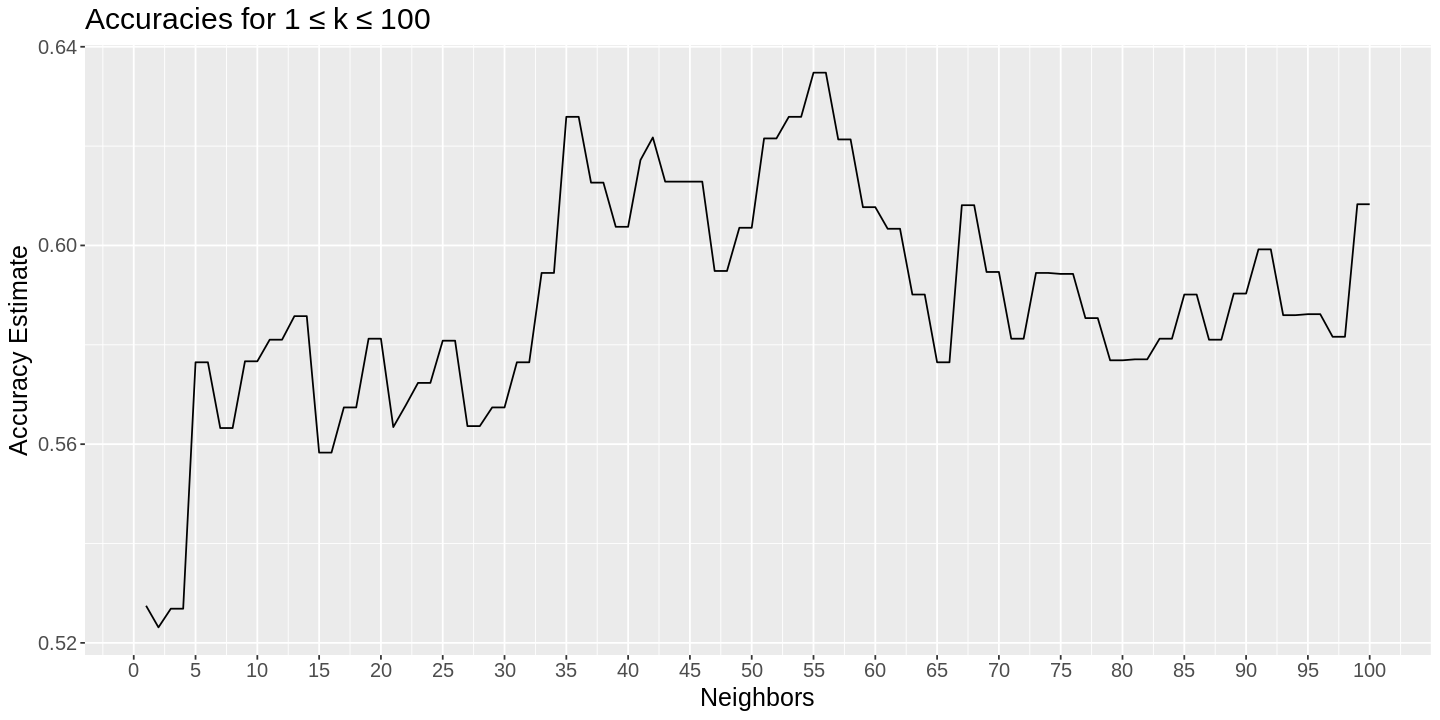

In [58]:
result_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 100") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

result_plot

EXPLANATION HERE

### Comparing to a majority of classifier

EXPLANATION HERE

EXPLANATION HERE

In [59]:
cleveland_proportion <- cleveland_train |>
        group_by(diag) |>
        summarize(n=n()) |>
        mutate(percentage = 100 * n / nrow(cleveland_train))

cleveland_proportion

diag  n   percentage
1 FALSE 120 54.05405  
2 TRUE  102 45.94595

EXPLANATION HERE

### Building the final working model

EXPLANATION HERE

In [60]:
set.seed(12)

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 52) |>
        set_engine("kknn") |>
        set_mode("classification")

final_recipe <- recipe(diag ~ chol + age, data = cleveland_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())

final_fit <- workflow() |>
        add_recipe(final_recipe) |>
        add_model(final_spec) |>
        fit(data = cleveland_train)
final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(52,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4054054
Best kernel: rectangular
Best k: 52

Now, we have a working model!

### Checking for over/underfitting

EXPLANATION HERE

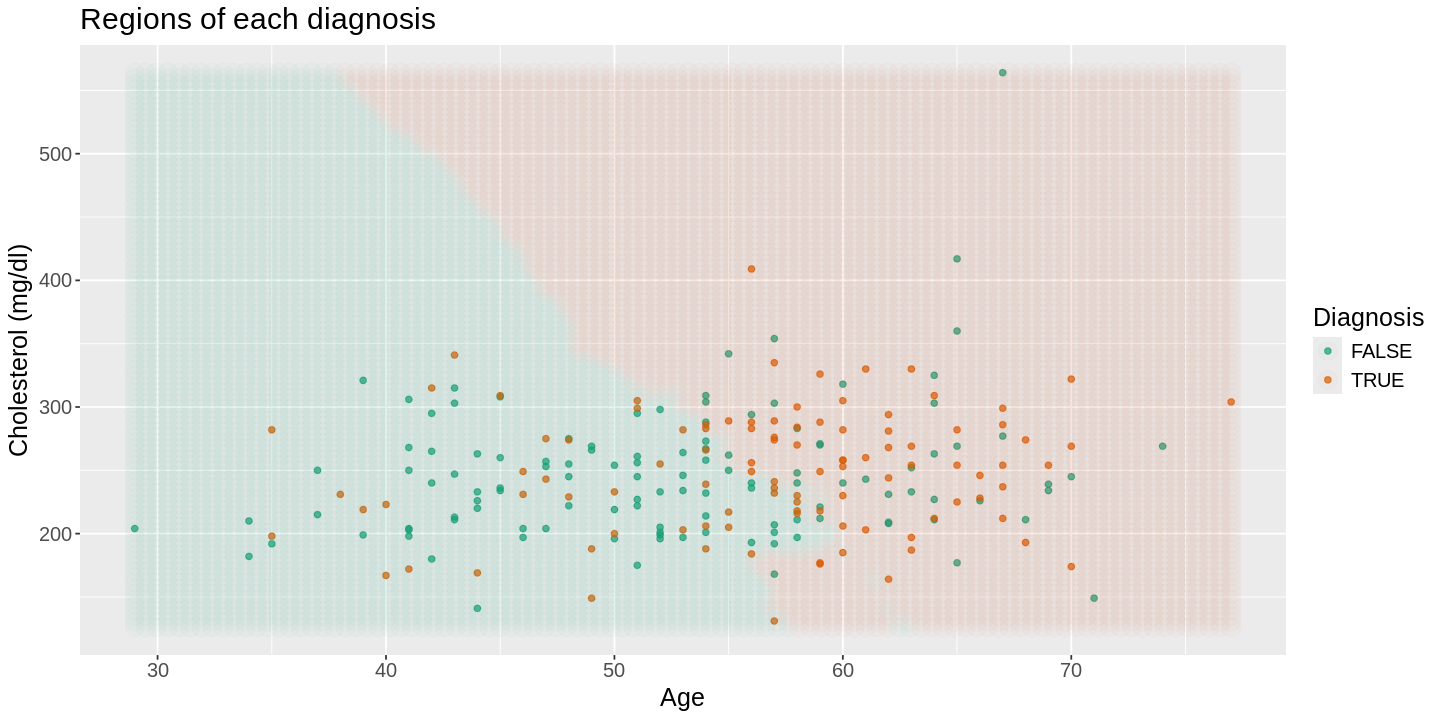

In [61]:
set.seed(12)

#make the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 52) |>
    set_engine("kknn") |>
    set_mode("classification")

#combine the model and recipe in a workflow, retrain the classifier with fit
fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(knn_spec) |>
    fit(data = cleveland_train)

#graph with coloured background to check for overfitting/underfitting

age_grid <- seq(min(cleveland_clean$age), 
                max(cleveland_clean$age), 
                length.out = 100)

chol_grid <- seq(min(cleveland_clean$chol), 
                max(cleveland_clean$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(age = age_grid, 
                                chol = chol_grid))

knnPredGrid <- predict(fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
                    rename(diag = .pred_class)

plot_results <- ggplot() + 
                geom_point(data = cleveland_train, 
                mapping = aes(x = age, y = chol, color = diag), 
                alpha = 0.7) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = age, 
                           y = chol, 
                           color = diag), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Age", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 15))

plot_results

EXPLANATION HERE

### Testing classifier

#### Accuracy and confusion matrix

EXPLANATION HERE

In [62]:
set.seed(12)

#predict
predictions <- predict(fit, cleveland_test) |>
               bind_cols(cleveland_test)

#find the accuracy of the predictions
metrics<- predictions |>
    metrics(truth = diag, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions |>
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

.metric  .estimator .estimate
1 accuracy binary     0.6133333

          Truth
Prediction FALSE TRUE
     FALSE    25   14
     TRUE     15   21

EXPLANATION HERE

#### Testing the versatility of classifier

EXPLANATION HERE

EXPLANATION HERE

In [63]:
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_names = FALSE)


colnames(switzerland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
                           
# changing "?" into NA
switzerland_data[ switzerland_data == "?" ] <- NA

# adding diag column, setting col types
# as.integer is being used to get rid of decimal points when switching to factor
switzerland_clean <- switzerland_data |>
                    mutate(diag = as.factor(ifelse(is.na(num), NA, (num > 0)))) %>%
                    mutate(thalach = as.double(thalach), chol = as.double(chol)) %>%
                    filter(chol != "NA",
                          age != "NA")

head(switzerland_clean)
nrow(switzerland_clean)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num
1 32  1   1  95       0    NA  0       127     0     .7      1     NA NA   1  
2 34  1   4  115      0    NA  NA      154     0     .2      1     NA NA   1  
3 35  1   4  NA       0    NA  0       130     1     NA      NA    NA 7    3  
4 36  1   4  110      0    NA  0       125     1     1       2     NA 6    1  
5 38  0   4  105      0    NA  0       166     0     2.8     1     NA NA   2  
6 38  0   4  110      0    0   0       156     0     0       2     NA 3    1  
  diag
1 TRUE
2 TRUE
3 TRUE
4 TRUE
5 TRUE
6 TRUE

[1] 123

EXPLANATION HERE

EXPLANATION HERE

#### Testing classifier on the Switzerland dataset

EXPLANATION HERE

In [49]:
switzerland_predictions <- predict(fit, switzerland_clean) |>
                      bind_cols(switzerland_clean)

#find the accuracy of the predictions
metrics<- switzerland_predictions |>
    metrics(truth = diag, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- switzerland_predictions |>
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

.metric  .estimator .estimate 
1 accuracy binary     0.06504065

          Truth
Prediction FALSE TRUE
     FALSE     8  115
     TRUE      0    0

EXPLANATION HERE

EXPLANATION HERE

## Discussion

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE

EXPLANATION HERE